<a href="https://colab.research.google.com/github/Ntwenhle17/gdp-dashboard/blob/main/Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Step 1: Install required libraries
!pip install -q pandas numpy matplotlib seaborn scikit-learn fairlearn aif360


In [15]:
import pandas as pd
from sklearn.datasets import fetch_openml

# Load Adult dataset from OpenML
adult = fetch_openml(data_id=1590, as_frame=True)
df = adult.frame.copy()

# Standardize column names
df.columns = [c.strip().replace('-', '_') for c in df.columns]

# Preview
df.head()


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Target column is 'class' (<=50K or >50K)
df['class'] = (df['class'].str.contains('>50K')).astype(int)

target = 'class'
sensitive = 'sex'              # fairness audit attribute
feature_interest = 'education' # for intersectional fairness

X = df.drop(columns=[target])
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Preprocess: OneHot encode categoricals, pass-through numerics
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)


In [17]:
# Logistic Regression baseline model
baseline_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('lr', LogisticRegression(max_iter=1000))
])

baseline_clf.fit(X_train, y_train)

# Predictions
y_pred = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)
print(f"Baseline accuracy: {baseline_acc:.3f}")


Baseline accuracy: 0.819


In [18]:
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, demographic_parity_difference

# Sensitive attribute: sex (Male vs Female)
sex_test = X_test['sex']

# Define fairness metrics
metrics = {
    'selection_rate': selection_rate,
    'true_positive_rate': true_positive_rate
}

# Compute fairness metrics by sex
mf = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sex_test
)

print("Fairness metrics by sex:")
print(mf.by_group)

# Demographic parity difference (overall fairness gap)
dp_diff = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sex_test
)
print(f"\nDemographic Parity Difference: {dp_diff:.3f}")


Fairness metrics by sex:
        selection_rate  true_positive_rate
sex                                       
Female        0.079274            0.392936
Male          0.154513            0.392467

Demographic Parity Difference: 0.075


Fairness metrics by sex × education (first 10 groups):
                     selection_rate  true_positive_rate
sensitive_feature_0                                    
Female | 10th              0.010000            0.000000
Female | 11th              0.006329            0.333333
Female | 12th              0.000000            0.000000
Female | 1st-4th           0.000000            0.000000
Female | 5th-6th           0.000000            0.000000
Female | 7th-8th           0.000000            0.000000
Female | 9th               0.000000            0.000000
Female | Assoc-acdm        0.056962            0.266667
Female | Assoc-voc         0.069892            0.296296
Female | Bachelors         0.156589            0.369565


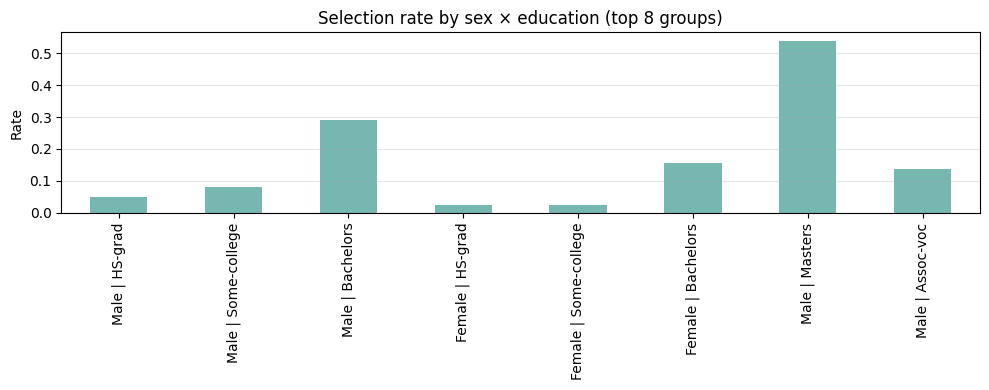

In [19]:
# Create intersectional group labels (sex × education)
intersection = X_test['sex'].astype(str) + " | " + X_test['education'].astype(str)

# Define metrics again
metrics = {
    'selection_rate': selection_rate,
    'true_positive_rate': true_positive_rate
}

# Compute fairness metrics by intersectional groups
mf_inter = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=intersection
)

print("Fairness metrics by sex × education (first 10 groups):")
print(mf_inter.by_group.head(10))

# Plot selection rates for top intersectional groups (by count)
counts = intersection.value_counts().head(8).index
sel_rates = mf_inter.by_group.loc[counts, 'selection_rate']

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sel_rates.plot(kind='bar', color='#76b7b2')
plt.title('Selection rate by sex × education (top 8 groups)')
plt.ylabel('Rate')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [20]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

# Fairness constraint: Demographic Parity
constraint = DemographicParity()

# Prepare preprocessed features
X_train_pre = preprocess.fit_transform(X_train)
X_test_pre  = preprocess.transform(X_test)

# Mitigated classifier
mitigated_clf = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=1000),
    constraints=constraint
)

# Train with fairness constraint
mitigated_clf.fit(X_train_pre, y_train, sensitive_features=X_train['sex'])

# Predictions after mitigation
y_pred_mitigated = mitigated_clf.predict(X_test_pre)

# Accuracy after mitigation
acc_mitigated = accuracy_score(y_test, y_pred_mitigated)

# Fairness metrics after mitigation
mf_mitigated = MetricFrame(
    metrics={'selection_rate': selection_rate, 'true_positive_rate': true_positive_rate},
    y_true=y_test,
    y_pred=y_pred_mitigated,
    sensitive_features=X_test['sex']
)

dp_diff_mitigated = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred_mitigated,
    sensitive_features=X_test['sex']
)

print(f"Baseline accuracy:     {baseline_acc:.3f}")
print(f"Mitigated accuracy:    {acc_mitigated:.3f}")
print(f"DP diff (baseline):    {dp_diff:.3f}")
print(f"DP diff (mitigated):   {dp_diff_mitigated:.3f}")

print("\nPer-group selection rate (baseline):")
print(mf.by_group['selection_rate'])
print("\nPer-group selection rate (mitigated):")
print(mf_mitigated.by_group['selection_rate'])


Baseline accuracy:     0.819
Mitigated accuracy:    0.785
DP diff (baseline):    0.075
DP diff (mitigated):   0.005

Per-group selection rate (baseline):
sex
Female    0.079274
Male      0.154513
Name: selection_rate, dtype: float64

Per-group selection rate (mitigated):
sex
Female    0.076541
Male      0.081959
Name: selection_rate, dtype: float64


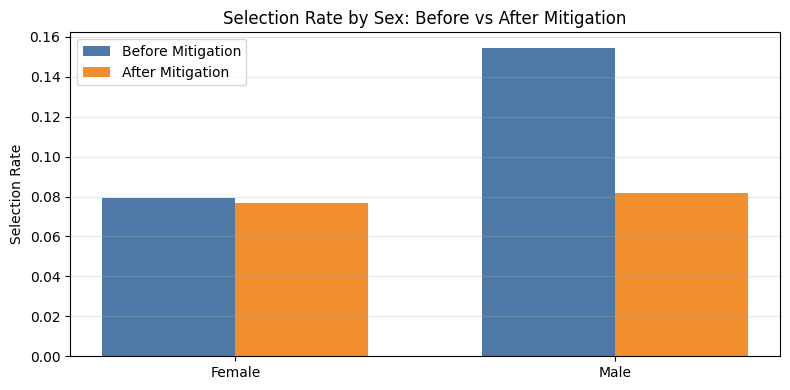

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Selection rates before and after mitigation
rates_before = mf.by_group['selection_rate']
rates_after  = mf_mitigated.by_group['selection_rate']

labels = rates_before.index.tolist()
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, rates_before.values, width, label='Before Mitigation', color='#4e79a7')
plt.bar(x + width/2, rates_after.values,  width, label='After Mitigation',  color='#f28e2c')

plt.xticks(x, labels, rotation=0)
plt.ylabel('Selection Rate')
plt.title('Selection Rate by Sex: Before vs After Mitigation')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [22]:

# Group predictions by sex and education
intersection = X_test['sex'].astype(str) + " | " + X_test['education'].astype(str)

mf_inter = MetricFrame(
    metrics={'selection_rate': selection_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=intersection
)

# Show selection rates for Male vs Female within each education level
print(mf_inter.by_group)


                       selection_rate
sensitive_feature_0                  
Female | 10th                0.010000
Female | 11th                0.006329
Female | 12th                0.000000
Female | 1st-4th             0.000000
Female | 5th-6th             0.000000
Female | 7th-8th             0.000000
Female | 9th                 0.000000
Female | Assoc-acdm          0.056962
Female | Assoc-voc           0.069892
Female | Bachelors           0.156589
Female | Doctorate           0.875000
Female | HS-grad             0.024960
Female | Masters             0.440860
Female | Preschool           0.000000
Female | Prof-school         0.682927
Female | Some-college        0.023213
Male | 10th                  0.012658
Male | 11th                  0.024691
Male | 12th                  0.025862
Male | 1st-4th               0.000000
Male | 5th-6th               0.009709
Male | 7th-8th               0.005348
Male | 9th                   0.000000
Male | Assoc-acdm            0.152893
Male | Assoc

In [23]:
import matplotlib.pyplot as plt

# Pivot selection rates into Male vs Female per education
sel_rates = mf_inter.by_group.reset_index()
sel_rates[['sex','education']] = sel_rates['index'].str.split(" | ", expand=True)

pivot = sel_rates.pivot(index='education', columns='sex', values='selection_rate')

pivot.plot(kind='bar', figsize=(10,5))
plt.title('Selection Rate by Education Level (Male vs Female)')
plt.ylabel('Selection Rate')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


KeyError: 'index'

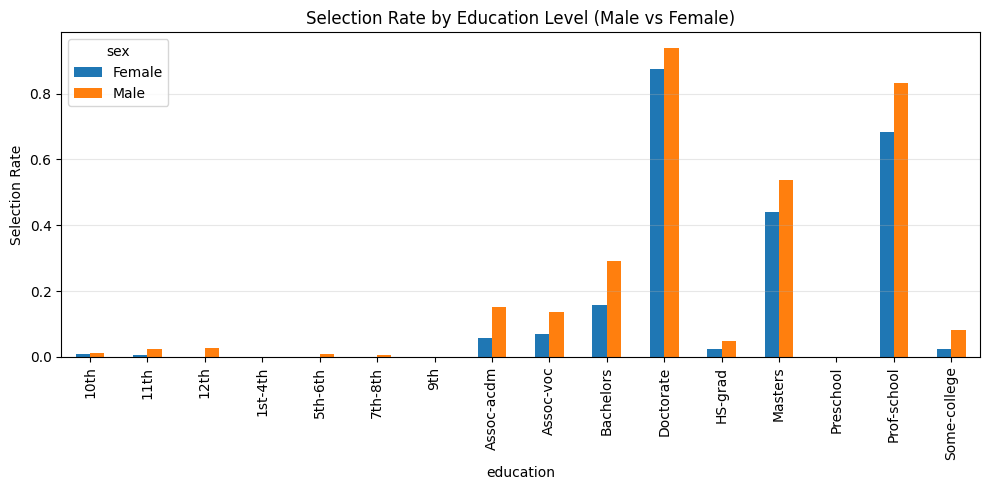

In [24]:
import matplotlib.pyplot as plt

# Reset index so group labels become a column
sel_rates = mf_inter.by_group.reset_index()

# Identify the column with group labels (usually the first one)
group_col = sel_rates.columns[0]

# Split group labels into sex and education
sel_rates[['sex','education']] = sel_rates[group_col].str.split("|", expand=True)

# Clean up whitespace
sel_rates['sex'] = sel_rates['sex'].str.strip()
sel_rates['education'] = sel_rates['education'].str.strip()

# Pivot into Male vs Female per education
pivot = sel_rates.pivot(index='education', columns='sex', values='selection_rate')

# Plot
pivot.plot(kind='bar', figsize=(10,5))
plt.title('Selection Rate by Education Level (Male vs Female)')
plt.ylabel('Selection Rate')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Reset index to turn group labels into a column
sel_rates = mf_inter.by_group.reset_index()

# The first column after reset_index() contains the group labels
group_col = sel_rates.columns[0]   # usually 'sensitive_feature' or similar

# Split group labels into sex and education
sel_rates[['sex','education']] = sel_rates[group_col].str.split(" | ", expand=True)

# Pivot into Male vs Female per education
pivot = sel_rates.pivot(index='education', columns='sex', values='selection_rate')

# Plot
pivot.plot(kind='bar', figsize=(10,5))
plt.title('Selection Rate by Education Level (Male vs Female)')
plt.ylabel('Selection Rate')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


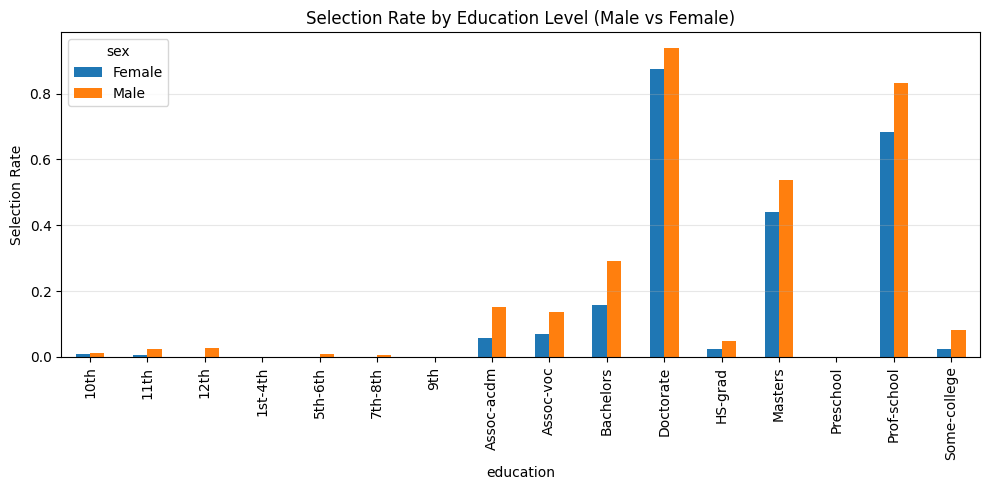

In [25]:
import matplotlib.pyplot as plt

# Reset index so group labels become a column
sel_rates = mf_inter.by_group.reset_index()

# Identify the column with group labels (first column)
group_col = sel_rates.columns[0]

# Split group labels into sex and education (use "|" without spaces)
sel_rates[['sex','education']] = sel_rates[group_col].str.split("|", expand=True)

# Clean up whitespace
sel_rates['sex'] = sel_rates['sex'].str.strip()
sel_rates['education'] = sel_rates['education'].str.strip()

# Pivot into Male vs Female per education
pivot = sel_rates.pivot(index='education', columns='sex', values='selection_rate')

# Plot
pivot.plot(kind='bar', figsize=(10,5))
plt.title('Selection Rate by Education Level (Male vs Female)')
plt.ylabel('Selection Rate')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Reset index so group labels become a column
sel_rates = mf_inter.by_group.reset_index()

# The first column after reset_index() contains the group labels
group_col = sel_rates.columns[0]   # usually 'sensitive_feature'

# Split group labels into sex and education
sel_rates[['sex','education']] = sel_rates[group_col].str.split(" | ", expand=True)

# Pivot into Male vs Female per education
pivot = sel_rates.pivot(index='education', columns='sex', values='selection_rate')

# Plot
pivot.plot(kind='bar', figsize=(10,5))
plt.title('Selection Rate by Education Level (Male vs Female)')
plt.ylabel('Selection Rate')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Reset index so group labels become a column
sel_rates = mf_inter.by_group.reset_index()

# Inspect the first few rows to see the actual format
print(sel_rates.head())

# Assume the first column holds group labels
group_col = sel_rates.columns[0]

# Try splitting on "|" without spaces
sel_rates[['sex','education']] = sel_rates[group_col].str.split("|", expand=True)

# Clean up whitespace
sel_rates['sex'] = sel_rates['sex'].str.strip()
sel_rates['education'] = sel_rates['education'].str.strip()

# Pivot into Male vs Female per education
pivot = sel_rates.pivot(index='education', columns='sex', values='selection_rate')

# Plot
pivot.plot(kind='bar', figsize=(10,5))
plt.title('Selection Rate by Education Level (Male vs Female)')
plt.ylabel('Selection Rate')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


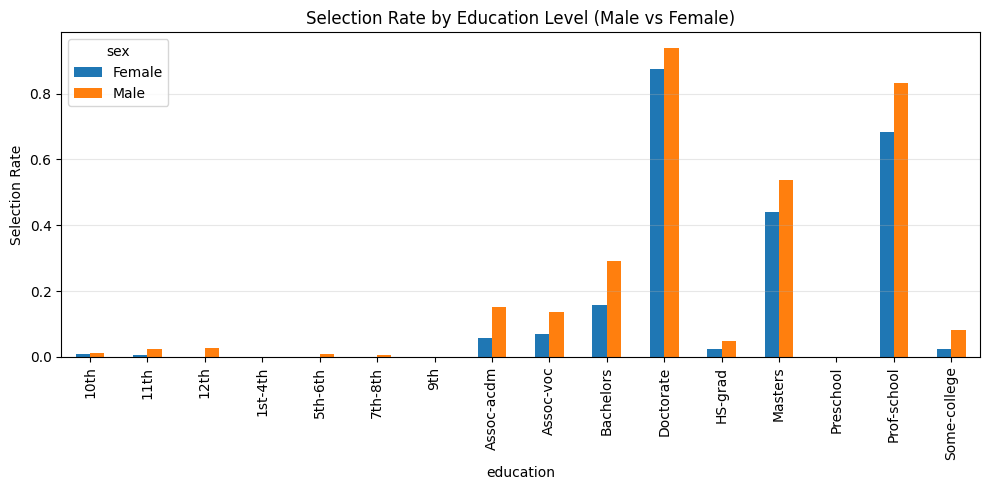

In [26]:
import matplotlib.pyplot as plt

# Reset index so group labels become a column
sel_rates = mf_inter.by_group.reset_index()

# Identify the column with group labels (first column)
group_col = sel_rates.columns[0]

# Split group labels into sex and education (use "|" without spaces)
sel_rates[['sex','education']] = sel_rates[group_col].str.split("|", expand=True)

# Clean up whitespace
sel_rates['sex'] = sel_rates['sex'].str.strip()
sel_rates['education'] = sel_rates['education'].str.strip()

# Pivot into Male vs Female per education
pivot = sel_rates.pivot(index='education', columns='sex', values='selection_rate')

# Plot
pivot.plot(kind='bar', figsize=(10,5))
plt.title('Selection Rate by Education Level (Male vs Female)')
plt.ylabel('Selection Rate')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
